In [122]:
%matplotlib inline
import requests, zipfile, io, re
import pandas as pd
# Sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
# Training model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
# Performance matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
# Tunning
from sklearn.model_selection import RandomizedSearchCV

In [123]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Downloading data

In [124]:
url = 'https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip' 
request = requests.get(url, stream=True) 
zip = zipfile.ZipFile(io.BytesIO(request.content)) 
zip.extractall()

In [125]:
df = pd.read_csv('SMSSpamCollection', delimiter='\t', names=['Class', 'Message'])

In [126]:
df_1=df.copy()

df_1['Class'] = df_1['Class'].map({'ham': 0, 'spam': 1})

# Separate features and target
X = df['Message']
y = df['Class']

# Oversampling
# oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
# X_resampled_over, y_resampled_over = oversampler.fit_resample(X.values.reshape(-1, 1), y)

# Undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled_under, y_resampled_under = undersampler.fit_resample(X.values.reshape(-1, 1), y)

# Create DataFrames from resampled data
# df_resampled_over = pd.DataFrame(X_resampled_over, columns=['Message'])
# df_resampled_over['Class'] = y_resampled_over

df_resampled_under = pd.DataFrame(X_resampled_under, columns=['Message'])
df_resampled_under['Class'] = y_resampled_under

# Display results
print("Original class distribution:")
print(y.value_counts())
# print("\nOver-sampled class distribution:")
# print(pd.Series(y_resampled_over).value_counts())
print("\nUnder-sampled class distribution:")
print(pd.Series(y_resampled_under).value_counts())

# Optional: Display the resampled datasets
# print("\nOver-sampled DataFrame:")
# df_resampled_over.head()

print("\nUnder-sampled DataFrame:")
df_resampled_under.head()

Original class distribution:
Class
ham     4825
spam     747
Name: count, dtype: int64

Under-sampled class distribution:
Class
ham     747
spam    747
Name: count, dtype: int64

Under-sampled DataFrame:


,Message,Class
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham
2,"Sorry that took so long, omw now",ham
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham


In [127]:
df=df_resampled_under

In [128]:
df.shape

(1494, 2)

# Evaluate data

## Understand Data

In [129]:
df

,Message,Class
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham
2,"Sorry that took so long, omw now",ham
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham
...,...,...
1489,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam
1490,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam
1491,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam
1492,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam


In [130]:
df.shape

(1494, 2)

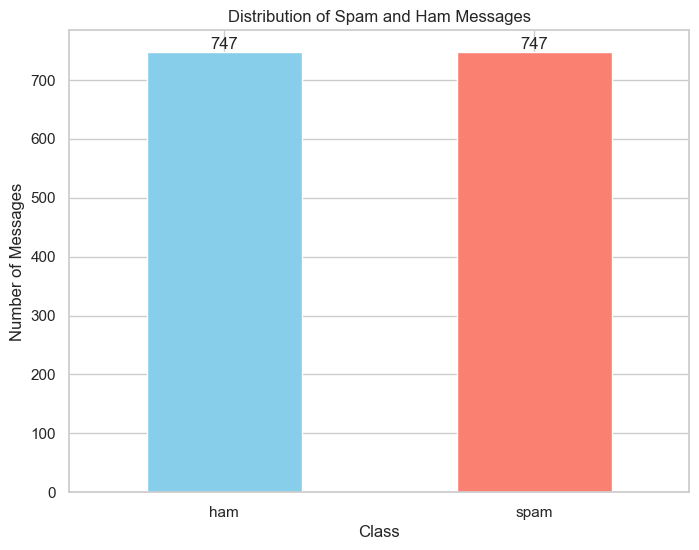

In [131]:
class_counts = df['Class'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = class_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Adding counts on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             int(bar.get_height()), 
             ha='center', 
             va='bottom')

plt.title("Distribution of Spam and Ham Messages")
plt.xlabel("Class")
plt.ylabel("Number of Messages")
plt.xticks(rotation=0)  
plt.show()

## Duplicated values

In [132]:
duplicate_count = df['Message'].duplicated().sum()

print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 116


In [133]:
duplicates = df[df.duplicated()]

print("Duplicate rows:")
duplicates

Duplicate rows:


,Message,Class
136,I cant pick the phone right now. Pls send a message,ham
175,"Sorry, I'll call later",ham
255,I will see in half an hour,ham
275,"Sorry, I'll call later",ham
282,Ok...,ham
...,...,...
1466,Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days.,spam
1477,December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on 08002986906,spam
1480,Get your garden ready for summer with a FREE selection of summer bulbs and seeds worth £33:50 only with The Scotsman this Saturday. To stop go2 notxt.co.uk,spam
1485,"SMS SERVICES. for your inclusive text credits, pls goto www.comuk.net login= 3qxj9 unsubscribe with STOP, no extra charge. help 08702840625.COMUK. 220-CM2 9AE",spam


In [134]:
# Drop duplicate rows
df_cleaned = df.drop_duplicates()

# Optionally, you can reset the index
df_cleaned.reset_index(drop=True, inplace=True)

print("DataFrame after dropping duplicates:")
df_cleaned

DataFrame after dropping duplicates:


,Message,Class
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham
2,"Sorry that took so long, omw now",ham
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham
...,...,...
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam
1375,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam
1376,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam


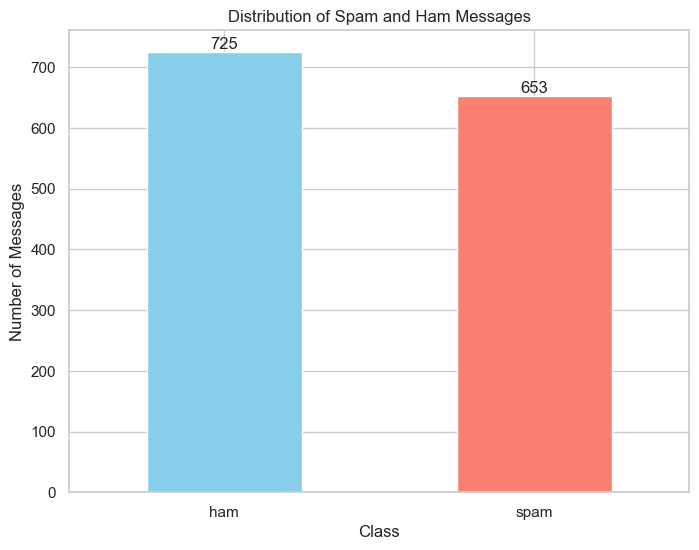

In [135]:
# after dropping duplicates
class_counts = df_cleaned['Class'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = class_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Adding counts on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             int(bar.get_height()), 
             ha='center', 
             va='bottom')

plt.title("Distribution of Spam and Ham Messages")
plt.xlabel("Class")
plt.ylabel("Number of Messages")
plt.xticks(rotation=0)  
plt.show()

## Missing values

In [136]:
missing_values = df_cleaned.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Message    0
Class      0
dtype: int64


## Outliers

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\2641595171.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



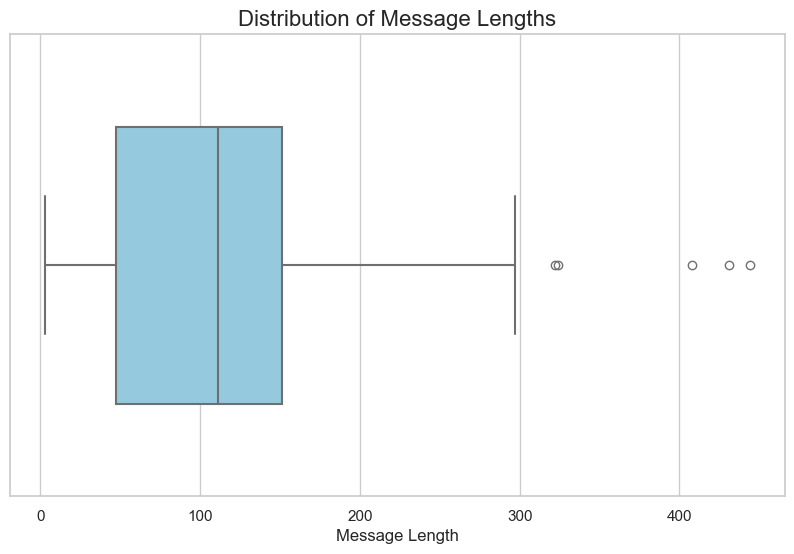

In [137]:
# Calculate message length
df_cleaned.loc[:,'Message_length'] = df_cleaned.loc[:,'Message'].apply(len)

# Create a colorful boxplot using a more suitable approach
plt.figure(figsize=(10, 6))

# Use a color palette and ensure no hue is required
sns.set(style="whitegrid")  # Set background style
sns.boxplot(x='Message_length', data=df_cleaned, color='skyblue', width=0.6, linewidth=1.5, showfliers=True)

# Add title and labels
plt.title("Distribution of Message Lengths", fontsize=16)
plt.xlabel("Message Length", fontsize=12)

# Show the plot
plt.show()

## Removing Outliers

In [138]:
count_greater_than_300 = df_cleaned[(df_cleaned['Message_length'] > 300)].shape[0]
print(f"Count of messages with length greater than 300: {count_greater_than_300}")

Count of messages with length greater than 300: 5


In [139]:
# Removing outliers
df_cleaned = df_cleaned[df_cleaned['Message_length'] <= 300]
df_cleaned.shape

(1373, 3)

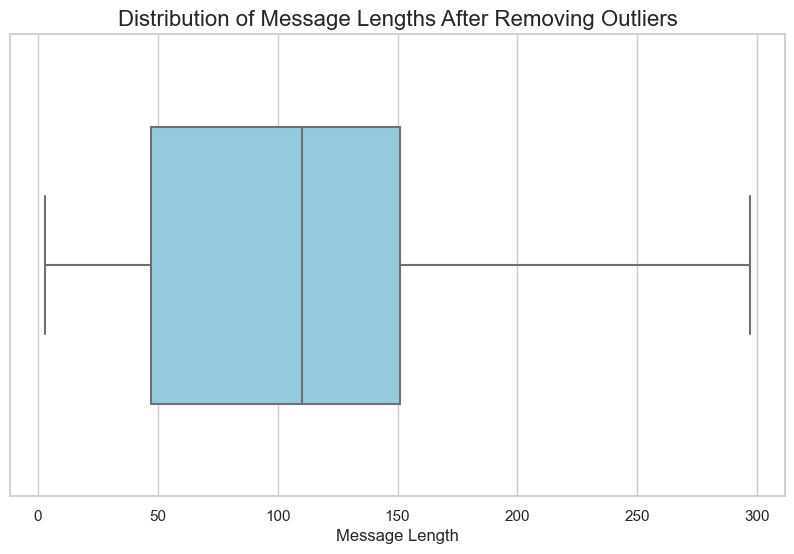

In [140]:
# Calculate message length
df_cleaned.loc[:,'Message_length'] = df_cleaned.loc[:,'Message'].apply(len)
 
# Create a colorful boxplot using a more suitable approach
plt.figure(figsize=(10, 6))
 
# Use a color palette and ensure no hue is required
sns.set(style="whitegrid")  # Set background style
sns.boxplot(x='Message_length', data=df_cleaned, color='skyblue', width=0.6, linewidth=1.5, showfliers=True)
 
# Add title and labels
plt.title("Distribution of Message Lengths After Removing Outliers", fontsize=16)
plt.xlabel("Message Length", fontsize=12)
 
# Show the plot
plt.show()

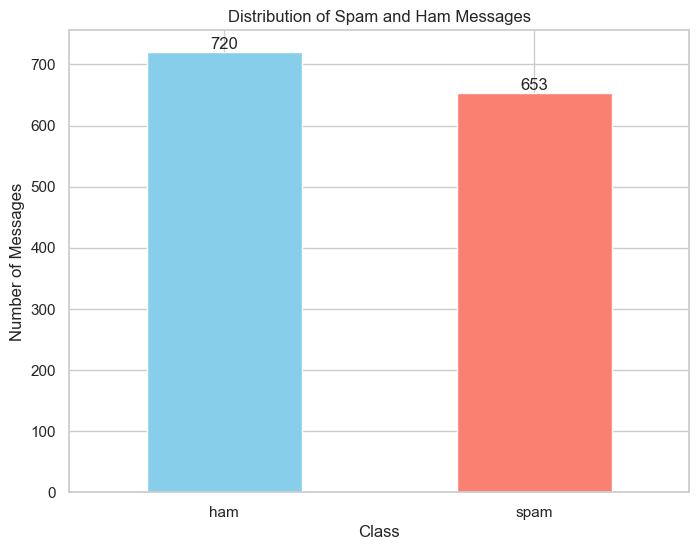

In [141]:
# after removing outliers
class_counts = df_cleaned['Class'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = class_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Adding counts on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             int(bar.get_height()), 
             ha='center', 
             va='bottom')

plt.title("Distribution of Spam and Ham Messages")
plt.xlabel("Class")
plt.ylabel("Number of Messages")
plt.xticks(rotation=0)  
plt.show()

## Create WordCloud

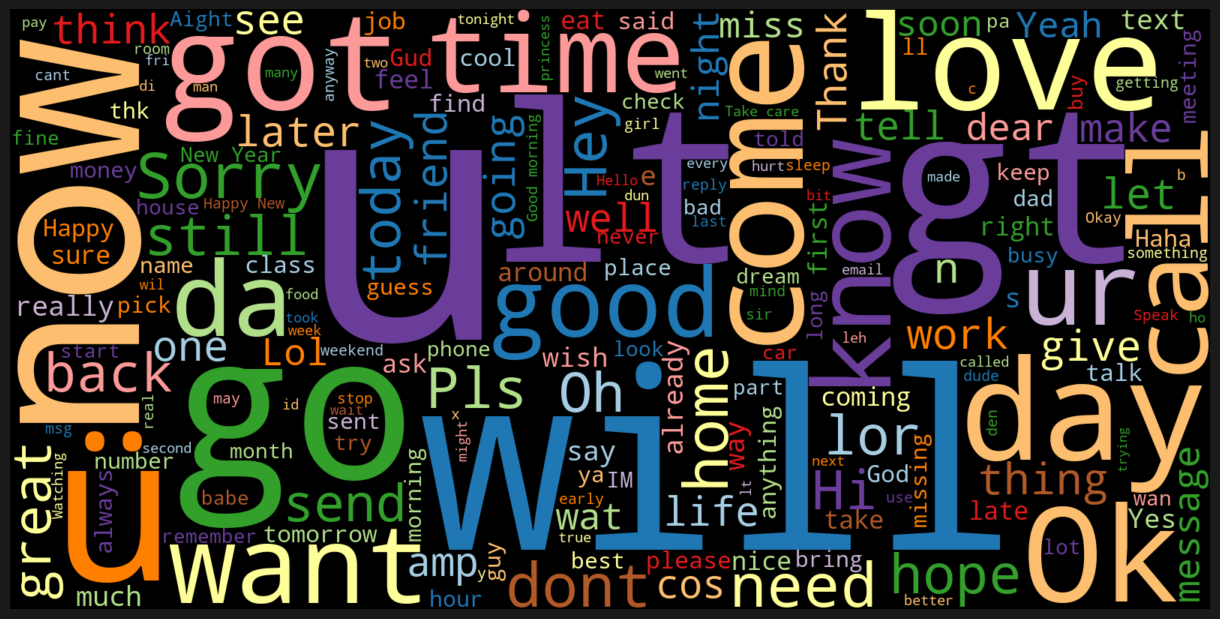

In [142]:
ham_msgs = ''
for index, row in df_cleaned.iterrows():
    # Check if the 'Class' is 'ham' using an if statement
    if row['Class'] == 'ham':
        ham_msgs+=row['Message']+" "

wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(ham_msgs)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

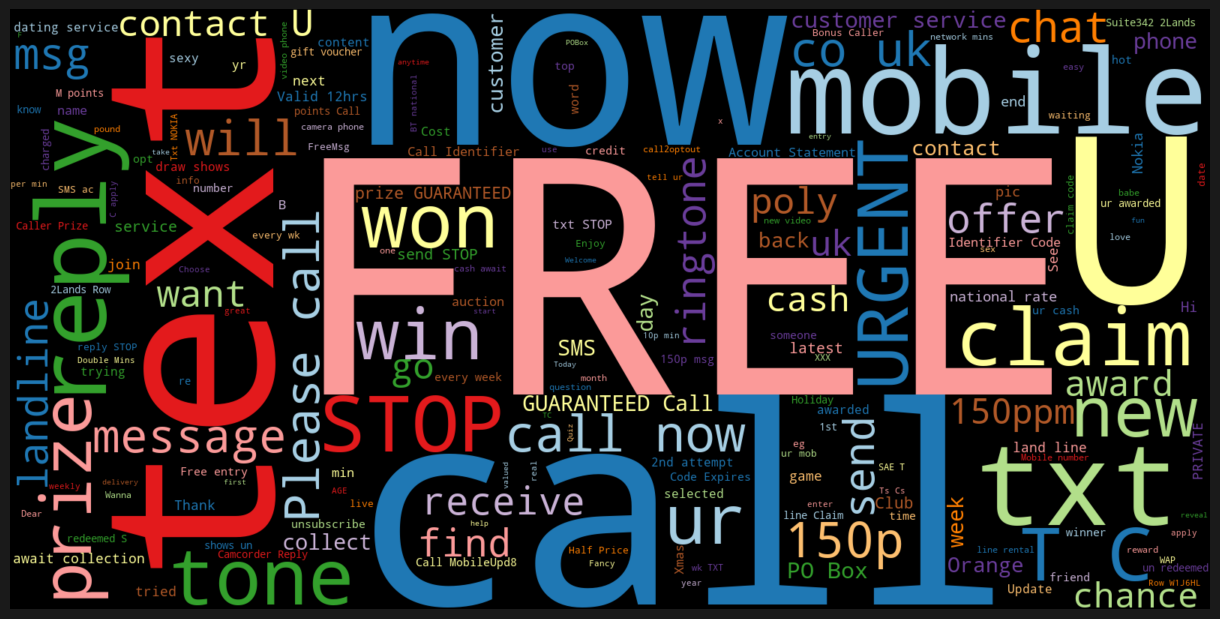

In [143]:
spam_msgs = ''
for index, row in df_cleaned.iterrows():
    # Check if the 'Class' is 'ham' using an if statement
    if row['Class'] == 'spam':
        spam_msgs+=row['Message']+" "

wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(spam_msgs)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [144]:
df_cleaned['Message'].isnull().value_counts()

Message
False    1373
Name: count, dtype: int64

# Feature Engineering

## Create additional features

In [145]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Add contain url

In [146]:
url_pattern = re.compile(
    r'(^|\s)'         # URL starts at the beginning of the string or after a space
    r'(https?://)?'    # Optional http or https
    r'(www\.)?'        # Optional www
    r'[a-zA-Z0-9-]+'   # Domain name part (letters, numbers, hyphens)
    r'\.'              # Dot before the top-level domain
    r'(com|org|net|edu|gov|co|io|info|biz|us|tv|ly|top)'   # Top-level domain (like com, org, net, etc.)
    r'(/[a-zA-Z0-9\-._~!$&\'()*+,;=:@%]*)?'  # Optional path after the domain
    r'(\?[a-zA-Z0-9\-._~!$&\'()*+,;=:@%]*)?'  # Optional query string after "?"
    r'(#\S*)?'                        # Optional fragment identifier after "#"
)

def is_url(text):
    return bool(url_pattern.search(text))

def contain_url(row):
    return is_url(row['Message'])

text1 = 'google.com'
text2 = 'https://github.com/'

print(is_url(text1))
print(is_url(text2))

True
True


In [147]:
df_cleaned.loc[:,'Contain URL'] = df_cleaned.apply(contain_url, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\3011591413.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Message,Class,Message_length,Contain URL
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham,84,False
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham,103,False
2,"Sorry that took so long, omw now",ham,32,False
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham,84,False
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham,111,False
...,...,...,...,...
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam,90,False
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam,158,False
1375,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam,160,False
1376,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam,147,False


In [148]:
df_url = df_cleaned[(df_cleaned['Contain URL'] == True)]
df_url

,Message,Class,Message_length,Contain URL
564,"Hi, Mobile no. &lt;#&gt; has added you in their contact list on www.fullonsms.com It s a great place to send free sms to people For more visit fullonsms.com",ham,158,True
650,Message:some text missing* Sender:Name Missing* *Number Missing *Sent:Date missing *Missing U a lot thats y everything is missing sent via fullonsms.com,ham,152,True
730,"URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18",spam,155,True
731,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL",spam,149,True
757,Are you unique enough? Find out from 30th August. www.areyouunique.co.uk,spam,72,True
...,...,...,...,...
1352,XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC www.Ldew.com1win150ppmx3age16subscription,spam,155,True
1364,For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit www.shortbreaks.org.uk,spam,108,True
1365,Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop www.gamb.tv,spam,147,True
1366,http//tms. widelive.com/index. wml?id=820554ad0a1705572711&first=true¡C C Ringtone¡,spam,83,True


### Add contain phone number

In [149]:
phone_pattern = re.compile(
    r'(?<!\d)'              # Negative lookbehind to ensure the number doesn't start in the middle of another number
    r'(\+?\d{4}|\d{3})?'    # Optional country code or leading number (e.g., +44 or 0800)
    r'(\d{3,4})'            # First part of the phone number (3 or 4 digits)
    r'[\s-]?'               # Optional space or dash
    r'(\d{3,4})'            # Second part of the phone number (3 or 4 digits)
    r'[\s-]?'               # Optional space or dash
    r'(\d{4})'              # Final part of the phone number (always 4 digits)
    r'(?=\D|$)'             # Ensures it ends with a non-digit or the end of the string
)

def is_phone_number(text):
    return bool(phone_pattern.search(text))

def contain_phone_number(row):
    return is_phone_number(row['Message'])

phone1 = '09064012160'
phone2 = 'call09050000327'
phone3 = '0800 542 0825'
phone4 = '08704439680Ts&Cs'
phone5 = 'Some text here and the number is 08002988890 and another 0870 444 9680.'

print(is_phone_number(phone1))
print(is_phone_number(phone2))
print(is_phone_number(phone3))
print(is_phone_number(phone4))
print(is_phone_number(phone5))

True
True
True
True
True


In [150]:
df_cleaned.loc[:,'Contain Phone Number'] = df_cleaned.apply(contain_phone_number, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\808680980.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Message,Class,Message_length,Contain URL,Contain Phone Number
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham,84,False,False
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham,103,False,False
2,"Sorry that took so long, omw now",ham,32,False,False
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham,84,False,False
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham,111,False,False
...,...,...,...,...,...
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam,90,False,True
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam,158,False,False
1375,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam,160,False,False
1376,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam,147,False,False


In [151]:
df_phone = df_cleaned[df_cleaned['Contain Phone Number'] == True]
df_phone['Message']

725                      Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
727                    WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
728                       Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
734     07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow
736                Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! 
                                                                                            ...

### Add contain email

In [152]:
email_pattern = re.compile(
    r'\b[A-Za-z0-9._%+-]+@\s*[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b'
)

def is_email(text):
    return bool(email_pattern.search(text))

def contain_email(row):
    return is_email(row['Message'])

email1 = 'olowoyey@ usc.edu'
email2 = 'Dorothy@kiefer.com'
email3 = 'customersqueries@netvision.uk.com'
email4 = 'yijue@hotmail.com'
email5 = 'msgs@150p'
email6 = 'chrgd@50p'
email7 = 'msg@£1.50rcvd'
email8 = 'XCLUSIVE@CLUBSAISAI'

print(is_email(email1))
print(is_email(email2))
print(is_email(email3))
print(is_email(email4))
print(is_email(email5))
print(is_email(email6))
print(is_email(email7))
print(is_email(email8))

True
True
True
True
False
False
False
False


In [153]:
df_cleaned.loc[:,'Contain Email'] = df_cleaned.apply(contain_email, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\1758939161.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham,84,False,False,False
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham,103,False,False,False
2,"Sorry that took so long, omw now",ham,32,False,False,False
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham,84,False,False,False
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham,111,False,False,False
...,...,...,...,...,...,...
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam,90,False,True,False
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam,158,False,False,False
1375,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam,160,False,False,False
1376,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam,147,False,False,False


In [154]:
df_email = df_cleaned[df_cleaned['Contain Email'] == True]
df_email

,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email
945,RT-KIng Pro Video Club>> Need help? info@ringtoneking.co.uk or call 08701237397 You must be 16+ Club credits redeemable at www.ringtoneking.co.uk! Enjoy!,spam,153,True,True,True
1031,"tddnewsletter@emc1.co.uk (More games from TheDailyDraw) Dear Helen, Dozens of Free Games - with great prizesWith..",spam,114,False,False,True
1052,"Text82228>> Get more ringtones, logos and games from www.txt82228.com. Questions: info@txt82228.co.uk",spam,101,True,False,True
1155,Dorothy@kiefer.com (Bank of Granite issues Strong-Buy) EXPLOSIVE PICK FOR OUR MEMBERS *****UP OVER 300% *********** Nasdaq Symbol CDGT That is a $5.00 per..,spam,156,False,False,True
1308,Warner Village 83118 C Colin Farrell in SWAT this wkend @Warner Village & get 1 free med. Popcorn!Just show msg+ticket@kiosk.Valid 4-7/12. C t&c @kiosk. Reply SONY 4 mre film offers,spam,181,False,False,True
1333,This msg is for your mobile content order It has been resent as previous attempt failed due to network error Queries to customersqueries@netvision.uk.com,spam,153,False,False,True


### Add contain currency symbol and currency symbol appearance count

In [155]:
currency_pattern = re.compile(r'[\$\€\£]')

def contain_currency_symbol(row):
    return bool(currency_pattern.search(row['Message']))

def count_currency_symbol(row):
    return len(currency_pattern.findall(row['Message']))

In [156]:
df_cleaned.loc[:,'Contain Currency Symbol'] = df_cleaned.apply(contain_currency_symbol, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\3443455103.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham,84,False,False,False,False
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham,103,False,False,False,False
2,"Sorry that took so long, omw now",ham,32,False,False,False,False
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham,84,False,False,False,False
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham,111,False,False,False,False
...,...,...,...,...,...,...,...
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam,90,False,True,False,False
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam,158,False,False,False,True
1375,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam,160,False,False,False,False
1376,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam,147,False,False,False,False


In [157]:
df_currency = df_cleaned[df_cleaned['Contain Currency Symbol'] == True]
df_currency

,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol
18,"YEH I AM DEF UP4 SOMETHING SAT,JUST GOT PAYED2DAY & I HAVBEEN GIVEN A£50 PAY RISE 4MY WORK & HAVEBEEN MADE PRESCHOOLCO-ORDINATOR 2I AM FEELINGOOD LUV",ham,149,False,False,False,True
271,"I got like $ &lt;#&gt; , I can get some more later though. Get whatever you feel like",ham,85,False,False,False,True
429,"Gumby's has a special where a &lt;#&gt; "" cheese pizza is $2 so I know what we're doin tonight",ham,95,False,False,False,True
594,"Yeah, that's fine! It's £6 to get in, is that ok?",ham,50,False,False,False,True
726,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",spam,147,False,False,False,True
...,...,...,...,...,...,...,...
1367,"URGENT! Last weekend's draw shows that you have won £1000 cash or a Spanish holiday! CALL NOW 09050000332 to claim. T&C: RSTM, SW7 3SS. 150ppm",spam,142,False,True,False,True
1368,URGENT We are trying to contact you Last weekends draw shows u have won a £1000 prize GUARANTEED Call 09064017295 Claim code K52 Valid 12hrs 150p pm,spam,148,False,True,False,True
1370,Marvel Mobile Play the official Ultimate Spider-man game (£4.50) on ur mobile right now. Text SPIDER to 83338 for the game & we ll send u a FREE 8Ball wallpaper,spam,160,False,False,False,True
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam,158,False,False,False,True


In [158]:
df_cleaned.loc[:,'Currency Symbol Count'] = df_cleaned.apply(count_currency_symbol, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\998390417.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham,84,False,False,False,False,0
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham,103,False,False,False,False,0
2,"Sorry that took so long, omw now",ham,32,False,False,False,False,0
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham,84,False,False,False,False,0
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham,111,False,False,False,False,0
...,...,...,...,...,...,...,...,...
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam,90,False,True,False,False,0
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam,158,False,False,False,True,2
1375,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam,160,False,False,False,False,0
1376,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam,147,False,False,False,False,0


In [159]:
df_currency_count = df_cleaned[df_cleaned['Currency Symbol Count'] > 1]
df_currency_count

,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count
738,"Urgent UR awarded a complimentary trip to EuroDisinc Trav, Aco&Entry41 Or £1000. To claim txt DIS to 87121 18+6*£1.50(moreFrmMob. ShrAcomOrSglSuplt)10, LS1 3AJ",spam,159,False,False,False,True,2
740,Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed £1000 cash or £5000 prize!,spam,137,False,True,False,True,2
756,Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!,spam,147,False,True,False,True,2
782,"FREE RINGTONE text FIRST to 87131 for a poly or text GET to 87131 for a true tone! Help? 0845 2814032 16 after 1st free, tones are 3x£150pw to e£nd txt stop",spam,156,False,True,False,True,2
789,"Loan for any purpose £500 - £75,000. Homeowners + Tenants welcome. Have you been previously refused? We can still help. Call Free 0800 1956669 or text back 'help'",spam,162,False,True,False,True,2
800,"Today's Offer! Claim ur £150 worth of discount vouchers! Text YES to 85023 now! SavaMob, member offers mobile! T Cs 08717898035. £3.00 Sub. 16 . Unsub reply X",spam,158,False,True,False,True,2
815,Todays Vodafone numbers ending with 4882 are selected to a receive a £350 award. If your number matches call 09064019014 to receive your £350 award.,spam,148,False,True,False,True,2
827,+449071512431 URGENT! This is the 2nd attempt to contact U!U have WON £1250 CALL 09071512433 b4 050703 T&CsBCM4235WC1N3XX. callcost 150ppm mobilesvary. max£7. 50,spam,161,False,True,False,True,2
828,You have WON a guaranteed £1000 cash or a £2000 prize. To claim yr prize call our customer service representative on 08714712394 between 10am-7pm,spam,145,False,True,False,True,2
835,Urgent Ur £500 guaranteed award is still unclaimed! Call 09066368327 NOW closingdate04/09/02 claimcode M39M51 £1.50pmmorefrommobile2Bremoved-MobyPOBox734LS27YF,spam,159,False,True,False,True,2


### Add contain HTML entities

In [160]:
html_entity_pattern = re.compile(r'&[a-zA-Z0-9#]+;')

def contain_html(row):
    return bool(html_entity_pattern.search(row['Message']))

In [161]:
df_cleaned.loc[:,'Contain HTML'] = df_cleaned.apply(contain_html, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\2553217130.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count,Contain HTML
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham,84,False,False,False,False,0,False
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham,103,False,False,False,False,0,False
2,"Sorry that took so long, omw now",ham,32,False,False,False,False,0,False
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham,84,False,False,False,False,0,False
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham,111,False,False,False,False,0,False
...,...,...,...,...,...,...,...,...,...
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam,90,False,True,False,False,0,False
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam,158,False,False,False,True,2,False
1375,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam,160,False,False,False,False,0,False
1376,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam,147,False,False,False,False,0,False


In [162]:
df_html = df_cleaned[df_cleaned['Contain HTML'] == True]
df_html

,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count,Contain HTML
6,somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true... goodnite &amp; sweet dreams,ham,144,False,False,False,False,0,True
12,Or I guess &lt;#&gt; min,ham,26,False,False,False,False,0,True
20,Hey you can pay. With salary de. Only &lt;#&gt; .,ham,50,False,False,False,False,0,True
35,"Do you know why god created gap between your fingers..? So that, One who is made for you comes &amp; fills those gaps by holding your hand with LOVE..!",ham,151,False,False,False,False,0,True
38,She left it very vague. She just said she would inform the person in accounting about the delayed rent and that i should discuss with the housing agency about my renting another place. But checking online now and all places around usc are &lt;#&gt; and up,ham,257,False,False,False,False,0,True
77,"Sir, good morning. Hope you had a good weekend. I called to let you know that i was able to raise &lt;#&gt; from my dad. He however said he would make the rest available by mid feb. This amount is still quite short and i was hoping you would help. Do have a good day. Abiola",ham,276,False,False,False,False,0,True
93,Pls give her prometazine syrup. 5mls then &lt;#&gt; mins later feed.,ham,69,False,False,False,False,0,True
170,"Watching cartoon, listening music &amp; at eve had to go temple &amp; church.. What about u?",ham,92,False,False,False,False,0,True
174,"I had been hoping i would not have to send you this message. My rent is due and i dont have enough for it. My reserves are completely gone. Its a loan i need and was hoping you could her. The balance is &lt;#&gt; . Is there a way i could get that from you, till mid march when i hope to pay back.",ham,297,False,False,False,False,0,True
186,I wud never mind if u dont miss me or if u dont need me.. But u wil really hurt me wen u need me &amp; u dont tell me......... Take care:-),ham,139,False,False,False,False,0,True


### Add contain special characters

In [163]:
special_char_pattern = re.compile(r'[^a-zA-Z0-9\s.,!?;:()\[\]{}\'\"-]')

def contain_special_character(row):
    return bool(special_char_pattern.search(row['Message']))

In [164]:
df_cleaned.loc[:,'Contain Special Character'] = df_cleaned.apply(contain_special_character, axis=1)
df_cleaned

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\1287236259.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count,Contain HTML,Contain Special Character
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham,84,False,False,False,False,0,False,True
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham,103,False,False,False,False,0,False,False
2,"Sorry that took so long, omw now",ham,32,False,False,False,False,0,False,False
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham,84,False,False,False,False,0,False,True
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham,111,False,False,False,False,0,False,True
...,...,...,...,...,...,...,...,...,...,...
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam,90,False,True,False,False,0,False,True
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam,158,False,False,False,True,2,False,True
1375,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam,160,False,False,False,False,0,False,True
1376,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam,147,False,False,False,False,0,False,False


In [165]:
df_special = df_cleaned[df_cleaned['Contain Special Character'] == True]
df_special

,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count,Contain HTML,Contain Special Character
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham,84,False,False,False,False,0,False,True
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham,84,False,False,False,False,0,False,True
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham,111,False,False,False,False,0,False,True
6,somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true... goodnite &amp; sweet dreams,ham,144,False,False,False,False,0,True,True
10,"Hello, my love! How goes that day ? I wish your well and fine babe and hope that you find some job prospects. I miss you, boytoy ... *a teasing kiss*",ham,149,False,False,False,False,0,False,True
...,...,...,...,...,...,...,...,...,...,...
1372,PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points. Call 08718738001 Identifier Code: 49557 Expires 26/11/04,spam,134,False,True,False,False,0,False,True
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam,90,False,True,False,False,0,False,True
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam,158,False,False,False,True,2,False,True
1375,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam,160,False,False,False,False,0,False,True


## Visuals

In [166]:
fig = px.histogram(df_special, x="Message_length")
fig.show()

In [167]:
fig = px.box(df_special, x="Message_length")
fig.show()

## Count messages containing URL

In [168]:
df_msg_URL = df_cleaned[(df_cleaned['Class'] == 'ham') & (df_cleaned['Contain URL'] == True)][['Contain URL','Message']]
df_msg_URL

,Contain URL,Message
564,True,"Hi, Mobile no. &lt;#&gt; has added you in their contact list on www.fullonsms.com It s a great place to send free sms to people For more visit fullonsms.com"
650,True,Message:some text missing* Sender:Name Missing* *Number Missing *Sent:Date missing *Missing U a lot thats y everything is missing sent via fullonsms.com


In [169]:
class_and_url = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain URL'])

<Figure size 1000x800 with 0 Axes>

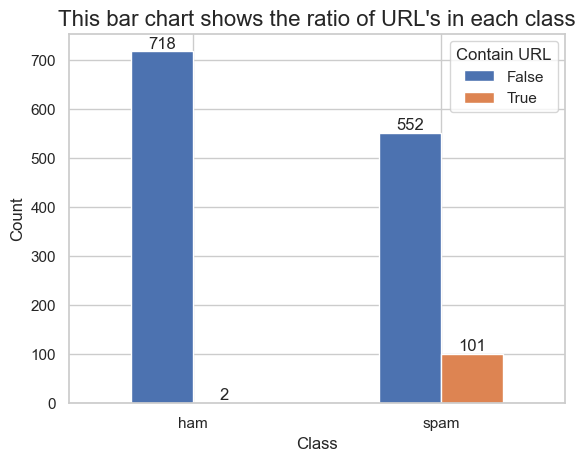

In [170]:
# Assuming class_and_url is your DataFrame or Series
plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_url.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of URL's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

## Count messages containing phone number

In [171]:
class_and_phone = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain Phone Number'])

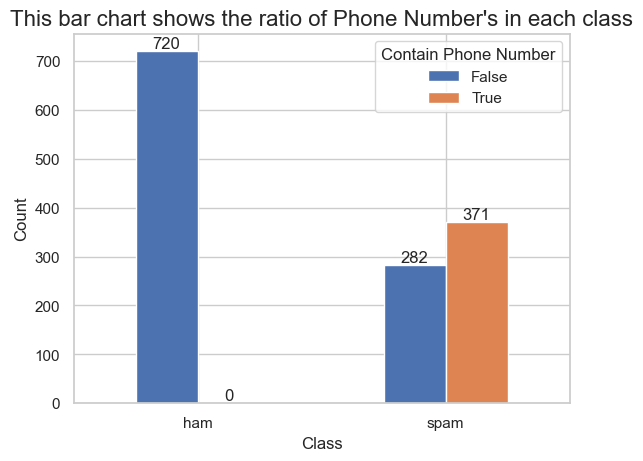

In [172]:
# Assuming class_and_url is your DataFrame or Series
#plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_phone.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of Phone Number's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

## Count messages containing email

In [173]:
class_and_email = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain Email'])

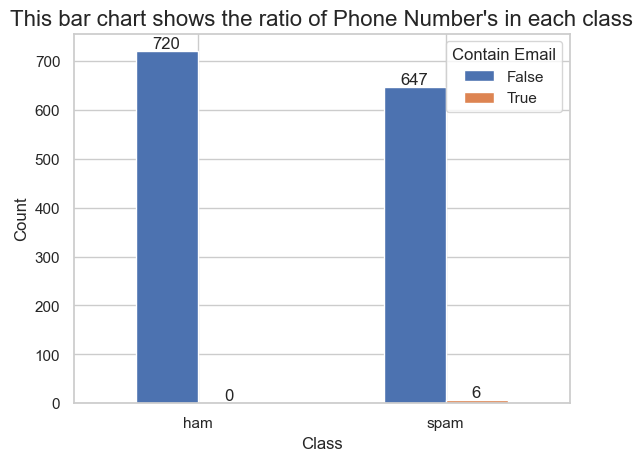

In [174]:
# Assuming class_and_url is your DataFrame or Series
#plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_email.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of Phone Number's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

## Count messages containing currency symbol

In [175]:
class_and_currency = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain Currency Symbol'])

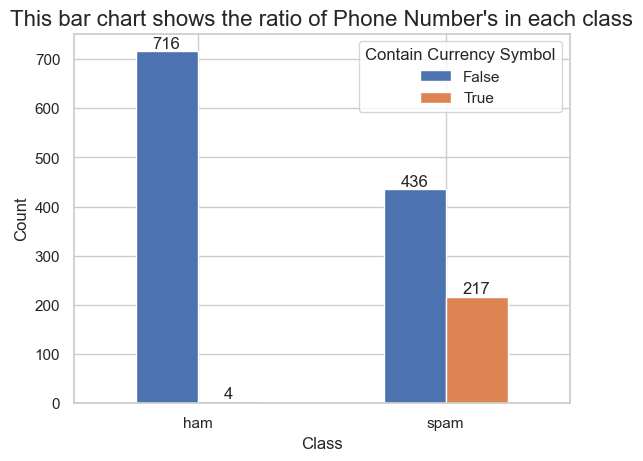

In [176]:
# Assuming class_and_url is your DataFrame or Series
#plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_currency.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of Phone Number's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

## Count messages containing HTML

In [177]:
class_and_html = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain HTML'])

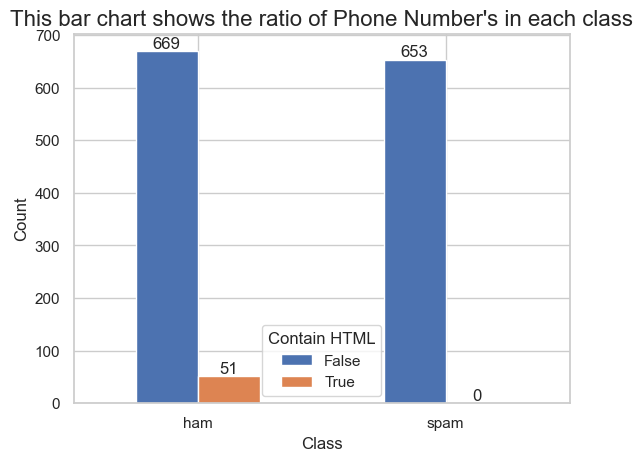

In [178]:
# Assuming class_and_url is your DataFrame or Series
#plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_html.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of Phone Number's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

## Count messages containing special characters

In [179]:
class_and_scharacter = pd.crosstab(df_cleaned['Class'], df_cleaned['Contain Special Character'])

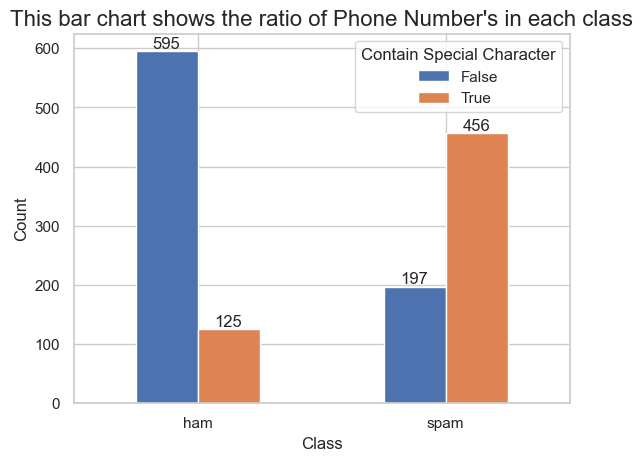

In [180]:
# Assuming class_and_url is your DataFrame or Series
#plt.figure(figsize=(10, 8))  # Adjusted the figure size

barplot = class_and_scharacter.plot.bar(rot=0)

# Optional: Add titles and labels
plt.title("This bar chart shows the ratio of Phone Number's in each class", fontsize=16)  # Add a title
plt.xlabel("Class", fontsize=12)  # Add an x-axis label
plt.ylabel("Count", fontsize=12)  # Add a y-axis label

# Add counts on top of each bar
for bar in barplot.patches:
    # Get the height of each bar and its position
    height = bar.get_height()
    # Add text annotation above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             int(height), ha='center', va='bottom')

plt.show()

# Text Preprocessing

In [181]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [182]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Message']

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\41747405.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Removing the HTML entities

In [183]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: html_entity_pattern.sub('', x))

In [184]:
df_cleaned[df_cleaned['Contain HTML'] == True][['Message', 'Cleaned']]

,Message,Cleaned
6,somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true... goodnite &amp; sweet dreams,somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true... goodnite sweet dreams
12,Or I guess &lt;#&gt; min,Or I guess # min
20,Hey you can pay. With salary de. Only &lt;#&gt; .,Hey you can pay. With salary de. Only # .
35,"Do you know why god created gap between your fingers..? So that, One who is made for you comes &amp; fills those gaps by holding your hand with LOVE..!","Do you know why god created gap between your fingers..? So that, One who is made for you comes fills those gaps by holding your hand with LOVE..!"
38,She left it very vague. She just said she would inform the person in accounting about the delayed rent and that i should discuss with the housing agency about my renting another place. But checking online now and all places around usc are &lt;#&gt; and up,She left it very vague. She just said she would inform the person in accounting about the delayed rent and that i should discuss with the housing agency about my renting another place. But checking online now and all places around usc are # and up
77,"Sir, good morning. Hope you had a good weekend. I called to let you know that i was able to raise &lt;#&gt; from my dad. He however said he would make the rest available by mid feb. This amount is still quite short and i was hoping you would help. Do have a good day. Abiola","Sir, good morning. Hope you had a good weekend. I called to let you know that i was able to raise # from my dad. He however said he would make the rest available by mid feb. This amount is still quite short and i was hoping you would help. Do have a good day. Abiola"
93,Pls give her prometazine syrup. 5mls then &lt;#&gt; mins later feed.,Pls give her prometazine syrup. 5mls then # mins later feed.
170,"Watching cartoon, listening music &amp; at eve had to go temple &amp; church.. What about u?","Watching cartoon, listening music at eve had to go temple church.. What about u?"
174,"I had been hoping i would not have to send you this message. My rent is due and i dont have enough for it. My reserves are completely gone. Its a loan i need and was hoping you could her. The balance is &lt;#&gt; . Is there a way i could get that from you, till mid march when i hope to pay back.","I had been hoping i would not have to send you this message. My rent is due and i dont have enough for it. My reserves are completely gone. Its a loan i need and was hoping you could her. The balance is # . Is there a way i could get that from you, till mid march when i hope to pay back."
186,I wud never mind if u dont miss me or if u dont need me.. But u wil really hurt me wen u need me &amp; u dont tell me......... Take care:-),I wud never mind if u dont miss me or if u dont need me.. But u wil really hurt me wen u need me u dont tell me......... Take care:-)


## Removing email

In [185]:
df_cleaned

,Message,Class,Message_length,Contain URL,Contain Phone Number,Contain Email,Contain Currency Symbol,Currency Symbol Count,Contain HTML,Contain Special Character,Cleaned
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,ham,84,False,False,False,False,0,False,True,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",ham,103,False,False,False,False,0,False,False,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it."
2,"Sorry that took so long, omw now",ham,32,False,False,False,False,0,False,False,"Sorry that took so long, omw now"
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,ham,84,False,False,False,False,0,False,True,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,ham,111,False,False,False,False,0,False,True,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.
...,...,...,...,...,...,...,...,...,...,...,...
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam,90,False,True,False,False,0,False,True,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX
1374,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,spam,158,False,False,False,True,2,False,True,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800
1375,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam,160,False,False,False,False,0,False,True,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records."
1376,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam,147,False,False,False,False,0,False,False,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode"


In [186]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: email_pattern.sub('', x))

In [187]:
df_cleaned[df_cleaned['Contain Email'] == True][['Message', 'Cleaned']]

,Message,Cleaned
945,RT-KIng Pro Video Club>> Need help? info@ringtoneking.co.uk or call 08701237397 You must be 16+ Club credits redeemable at www.ringtoneking.co.uk! Enjoy!,RT-KIng Pro Video Club>> Need help? or call 08701237397 You must be 16+ Club credits redeemable at www.ringtoneking.co.uk! Enjoy!
1031,"tddnewsletter@emc1.co.uk (More games from TheDailyDraw) Dear Helen, Dozens of Free Games - with great prizesWith..","(More games from TheDailyDraw) Dear Helen, Dozens of Free Games - with great prizesWith.."
1052,"Text82228>> Get more ringtones, logos and games from www.txt82228.com. Questions: info@txt82228.co.uk","Text82228>> Get more ringtones, logos and games from www.txt82228.com. Questions:"
1155,Dorothy@kiefer.com (Bank of Granite issues Strong-Buy) EXPLOSIVE PICK FOR OUR MEMBERS *****UP OVER 300% *********** Nasdaq Symbol CDGT That is a $5.00 per..,(Bank of Granite issues Strong-Buy) EXPLOSIVE PICK FOR OUR MEMBERS *****UP OVER 300% *********** Nasdaq Symbol CDGT That is a $5.00 per..
1308,Warner Village 83118 C Colin Farrell in SWAT this wkend @Warner Village & get 1 free med. Popcorn!Just show msg+ticket@kiosk.Valid 4-7/12. C t&c @kiosk. Reply SONY 4 mre film offers,Warner Village 83118 C Colin Farrell in SWAT this wkend @Warner Village & get 1 free med. Popcorn!Just show 4-7/12. C t&c @kiosk. Reply SONY 4 mre film offers
1333,This msg is for your mobile content order It has been resent as previous attempt failed due to network error Queries to customersqueries@netvision.uk.com,This msg is for your mobile content order It has been resent as previous attempt failed due to network error Queries to


## Removing URL

In [188]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: url_pattern.sub('', x))

In [189]:
df_cleaned[df_cleaned['Contain URL'] == True][['Message', 'Cleaned']]

,Message,Cleaned
564,"Hi, Mobile no. &lt;#&gt; has added you in their contact list on www.fullonsms.com It s a great place to send free sms to people For more visit fullonsms.com","Hi, Mobile no. # has added you in their contact list on It s a great place to send free sms to people For more visit"
650,Message:some text missing* Sender:Name Missing* *Number Missing *Sent:Date missing *Missing U a lot thats y everything is missing sent via fullonsms.com,Message:some text missing* Sender:Name Missing* *Number Missing *Sent:Date missing *Missing U a lot thats y everything is missing sent via
730,"URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18","URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C LCCLTD POBOX 4403LDNW1A7RW18"
731,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL","XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap."
757,Are you unique enough? Find out from 30th August. www.areyouunique.co.uk,Are you unique enough? Find out from 30th August..uk
...,...,...
1352,XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC www.Ldew.com1win150ppmx3age16subscription,XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC1win150ppmx3age16subscription
1364,For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit www.shortbreaks.org.uk,For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit.uk
1365,Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop www.gamb.tv,Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop
1366,http//tms. widelive.com/index. wml?id=820554ad0a1705572711&first=true¡C C Ringtone¡,http//tms. wml?id=820554ad0a1705572711&first=true¡C C Ringtone¡


## Remove phone number

In [190]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: phone_pattern.sub('', x))

In [191]:
df_cleaned[df_cleaned['Contain Phone Number'] == True][['Message', 'Cleaned']]

,Message,Cleaned
725,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply over18's
727,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call . Claim code KL341. Valid 12 hours only.
728,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on
734,07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow,- Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now for delivery tomorrow
736,"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!","Congrats! 1 year special cinema pass for 2 is yours. call now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!"
...,...,...
1369,2p per min to call Germany 08448350055 from your BT line. Just 2p per min. Check PlanetTalkInstant.com for info & T's & C's. Text stop to opt out,2p per min to call Germany from your BT line. Just 2p per min. Check for info & T's & C's. Text stop to opt out
1371,PRIVATE! Your 2003 Account Statement for 07808247860 shows 800 un-redeemed S. I. M. points. Call 08719899229 Identifier Code: 40411 Expires 06/11/04,PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call Identifier Code: 40411 Expires 06/11/04
1372,PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points. Call 08718738001 Identifier Code: 49557 Expires 26/11/04,PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points. Call Identifier Code: 49557 Expires 26/11/04
1373,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,Want explicit SEX in 30 secs? Ring now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX


## Removing punctuations

In [192]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [193]:
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [194]:
df_cleaned[['Message', 'Cleaned']].head(8)

,Message,Cleaned
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,If i not meeting ü all rite then ill go home lor If ü dun feel like comin its ok
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",Ill always be there even if its just in spirit Ill get a bb soon Just trying to be sure i need it
2,"Sorry that took so long, omw now",Sorry that took so long omw now
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,I thk 50 shd be ok he said plus minus 10 Did ü leave a line in between paragraphs
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,Dunno i juz askin cos i got a card got 20 off 4 a salon called hair sense so i tot its da one ü cut ur hair
5,Aight ill get on fb in a couple minutes,Aight ill get on fb in a couple minutes
6,somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true... goodnite &amp; sweet dreams,somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true goodnite sweet dreams
7,Slaaaaave ! Where are you ? Must I summon you to me all the time now ? Don't you wish to come to me on your own anymore?,Slaaaaave Where are you Must I summon you to me all the time now Dont you wish to come to me on your own anymore


## Remove number

In [195]:
number_pattern = re.compile(r'\b\w*\d+\w*\b')
df_cleaned.loc[:,'Cleaned'] = df_cleaned['Cleaned'].apply(lambda x: number_pattern.sub('', x))

In [196]:
df_cleaned[['Message', 'Cleaned']].head(8)

,Message,Cleaned
0,If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.,If i not meeting ü all rite then ill go home lor If ü dun feel like comin its ok
1,"I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.",Ill always be there even if its just in spirit Ill get a bb soon Just trying to be sure i need it
2,"Sorry that took so long, omw now",Sorry that took so long omw now
3,I thk 50 shd be ok he said plus minus 10.. Did ü leave a line in between paragraphs?,I thk shd be ok he said plus minus Did ü leave a line in between paragraphs
4,Dunno i juz askin cos i got a card got 20% off 4 a salon called hair sense so i tot it's da one ü cut ur hair.,Dunno i juz askin cos i got a card got off a salon called hair sense so i tot its da one ü cut ur hair
5,Aight ill get on fb in a couple minutes,Aight ill get on fb in a couple minutes
6,somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true... goodnite &amp; sweet dreams,somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true goodnite sweet dreams
7,Slaaaaave ! Where are you ? Must I summon you to me all the time now ? Don't you wish to come to me on your own anymore?,Slaaaaave Where are you Must I summon you to me all the time now Dont you wish to come to me on your own anymore


## Tokenization

In [197]:
df_cleaned.loc[:,'Tokenized'] = df_cleaned['Cleaned'].apply(lambda x: word_tokenize(x.lower()))

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\1210549041.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [198]:
df_cleaned[['Cleaned', 'Tokenized']].head(8)

,Cleaned,Tokenized
0,If i not meeting ü all rite then ill go home lor If ü dun feel like comin its ok,"[if, i, not, meeting, ü, all, rite, then, ill, go, home, lor, if, ü, dun, feel, like, comin, its, ok]"
1,Ill always be there even if its just in spirit Ill get a bb soon Just trying to be sure i need it,"[ill, always, be, there, even, if, its, just, in, spirit, ill, get, a, bb, soon, just, trying, to, be, sure, i, need, it]"
2,Sorry that took so long omw now,"[sorry, that, took, so, long, omw, now]"
3,I thk shd be ok he said plus minus Did ü leave a line in between paragraphs,"[i, thk, shd, be, ok, he, said, plus, minus, did, ü, leave, a, line, in, between, paragraphs]"
4,Dunno i juz askin cos i got a card got off a salon called hair sense so i tot its da one ü cut ur hair,"[dunno, i, juz, askin, cos, i, got, a, card, got, off, a, salon, called, hair, sense, so, i, tot, its, da, one, ü, cut, ur, hair]"
5,Aight ill get on fb in a couple minutes,"[aight, ill, get, on, fb, in, a, couple, minutes]"
6,somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true goodnite sweet dreams,"[somewhere, out, there, beneath, the, pale, moon, light, someone, think, in, of, u, some, where, out, there, where, dreams, come, true, goodnite, sweet, dreams]"
7,Slaaaaave Where are you Must I summon you to me all the time now Dont you wish to come to me on your own anymore,"[slaaaaave, where, are, you, must, i, summon, you, to, me, all, the, time, now, dont, you, wish, to, come, to, me, on, your, own, anymore]"


## Removing stop words

In [199]:
print(stop_words)

{'off', 'yourselves', 'its', 't', 'by', 'few', "don't", "didn't", 'theirs', 'does', 'them', 'nor', 'more', 'just', 'y', 'weren', 'ain', 'until', 'aren', 'do', 'other', 'o', 'how', 'mightn', 'shan', 'wasn', 'both', 'i', "it's", 'our', 'couldn', 'this', 'his', 'myself', 'wouldn', 'and', 'needn', 'themselves', 'to', "that'll", 'once', 'not', 'then', 'now', 'hers', 'no', "couldn't", 's', "haven't", "doesn't", 'between', 've', 'while', 'again', "you'll", 'hadn', 'than', 'on', 'had', 'as', 'will', 'against', 'him', 'those', 'been', 'above', "shan't", 'an', 'we', "you're", 'whom', 'is', 'are', 'am', 'she', 'through', "aren't", 'were', 'own', 'for', 'these', 'which', 'you', 'being', 'when', 'all', 'haven', 'itself', 'having', 'up', 'down', "shouldn't", 'did', 'can', "mustn't", 'why', 'm', 'didn', 'a', 'under', 'they', 'what', 'same', 'be', 'doing', 'their', 'during', "won't", 'any', 'who', 'after', 'ours', 'll', "mightn't", "weren't", 'her', "hadn't", 'each', 'here', 'some', 'won', 'himself', 

In [200]:
df_cleaned.loc[:,'Preprocessed'] = df_cleaned['Tokenized'].apply(lambda x: [word for word in x if word not in stop_words])

C:\Users\ashut\AppData\Local\Temp\ipykernel_41988\1483153977.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [201]:
df_cleaned[['Tokenized', 'Preprocessed']].head(8)

,Tokenized,Preprocessed
0,"[if, i, not, meeting, ü, all, rite, then, ill, go, home, lor, if, ü, dun, feel, like, comin, its, ok]","[meeting, ü, rite, ill, go, home, lor, ü, dun, feel, like, comin, ok]"
1,"[ill, always, be, there, even, if, its, just, in, spirit, ill, get, a, bb, soon, just, trying, to, be, sure, i, need, it]","[ill, always, even, spirit, ill, get, bb, soon, trying, sure, need]"
2,"[sorry, that, took, so, long, omw, now]","[sorry, took, long, omw]"
3,"[i, thk, shd, be, ok, he, said, plus, minus, did, ü, leave, a, line, in, between, paragraphs]","[thk, shd, ok, said, plus, minus, ü, leave, line, paragraphs]"
4,"[dunno, i, juz, askin, cos, i, got, a, card, got, off, a, salon, called, hair, sense, so, i, tot, its, da, one, ü, cut, ur, hair]","[dunno, juz, askin, cos, got, card, got, salon, called, hair, sense, tot, da, one, ü, cut, ur, hair]"
5,"[aight, ill, get, on, fb, in, a, couple, minutes]","[aight, ill, get, fb, couple, minutes]"
6,"[somewhere, out, there, beneath, the, pale, moon, light, someone, think, in, of, u, some, where, out, there, where, dreams, come, true, goodnite, sweet, dreams]","[somewhere, beneath, pale, moon, light, someone, think, u, dreams, come, true, goodnite, sweet, dreams]"
7,"[slaaaaave, where, are, you, must, i, summon, you, to, me, all, the, time, now, dont, you, wish, to, come, to, me, on, your, own, anymore]","[slaaaaave, must, summon, time, dont, wish, come, anymore]"


## Lemmatization

In [202]:
df_cleaned.loc[:,'Preprocessed'] = df_cleaned['Preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [203]:
df_cleaned[['Tokenized', 'Preprocessed']].head(8)

,Tokenized,Preprocessed
0,"[if, i, not, meeting, ü, all, rite, then, ill, go, home, lor, if, ü, dun, feel, like, comin, its, ok]","[meeting, ü, rite, ill, go, home, lor, ü, dun, feel, like, comin, ok]"
1,"[ill, always, be, there, even, if, its, just, in, spirit, ill, get, a, bb, soon, just, trying, to, be, sure, i, need, it]","[ill, always, even, spirit, ill, get, bb, soon, trying, sure, need]"
2,"[sorry, that, took, so, long, omw, now]","[sorry, took, long, omw]"
3,"[i, thk, shd, be, ok, he, said, plus, minus, did, ü, leave, a, line, in, between, paragraphs]","[thk, shd, ok, said, plus, minus, ü, leave, line, paragraph]"
4,"[dunno, i, juz, askin, cos, i, got, a, card, got, off, a, salon, called, hair, sense, so, i, tot, its, da, one, ü, cut, ur, hair]","[dunno, juz, askin, co, got, card, got, salon, called, hair, sense, tot, da, one, ü, cut, ur, hair]"
5,"[aight, ill, get, on, fb, in, a, couple, minutes]","[aight, ill, get, fb, couple, minute]"
6,"[somewhere, out, there, beneath, the, pale, moon, light, someone, think, in, of, u, some, where, out, there, where, dreams, come, true, goodnite, sweet, dreams]","[somewhere, beneath, pale, moon, light, someone, think, u, dream, come, true, goodnite, sweet, dream]"
7,"[slaaaaave, where, are, you, must, i, summon, you, to, me, all, the, time, now, dont, you, wish, to, come, to, me, on, your, own, anymore]","[slaaaaave, must, summon, time, dont, wish, come, anymore]"


# Vectorization

## Creating TF-IDF matrix

In [204]:
df_cleaned.loc[:,'Preprocessed'] = df_cleaned['Preprocessed'].apply(lambda x: ' '.join(x))

In [205]:
df_cleaned['Preprocessed']

0                                                                  meeting ü rite ill go home lor ü dun feel like comin ok
1                                                                  ill always even spirit ill get bb soon trying sure need
2                                                                                                      sorry took long omw
3                                                                        thk shd ok said plus minus ü leave line paragraph
4                                         dunno juz askin co got card got salon called hair sense tot da one ü cut ur hair
                                                               ...                                                        
1373                                                                            want explicit sex sec ring cost gsex pobox
1374          asked chatlines inclu free min india cust servs sed yes got mega bill dont giv shit bailiff due day £ want £
1375    contract

In [206]:
vectorizer = TfidfVectorizer(strip_accents='ascii', max_features=1000, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(df_cleaned['Preprocessed'])

In [207]:
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [208]:
df_tfidf

,access,account,account statement,action,activate,actually,address,admirer,admirer looking,age,...,yeah,year,yes,yesterday,yet,yo,youre,yr,yup,zed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.407476,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.204124,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [209]:
df_tfidf[df_tfidf['account'] > 0]

,access,account,account statement,action,activate,actually,address,admirer,admirer looking,age,...,yeah,year,yes,yesterday,yet,yo,youre,yr,yup,zed
739,0.0,0.227386,0.234785,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0.0,0.226895,0.234279,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
805,0.0,0.228468,0.235902,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
812,0.0,0.228468,0.235902,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
851,0.0,0.235643,0.243311,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
927,0.0,0.301695,0.000000,0.0,0.377961,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
937,0.0,0.228468,0.235902,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.0,0.362523,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1193,0.0,0.277042,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1219,0.0,0.228468,0.235902,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Creating a matrix for binary columns

In [210]:
additional_features = df_cleaned[['Contain URL', 'Contain Phone Number', 'Contain Currency Symbol']].astype(int)
additional_features

,Contain URL,Contain Phone Number,Contain Currency Symbol
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
1373,0,1,0
1374,0,0,1
1375,0,0,0
1376,0,0,0


In [211]:
df_tfidf.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)
df_matrix = pd.concat([df_tfidf, additional_features], axis=1)

In [212]:
df_matrix

,access,account,account statement,action,activate,actually,address,admirer,admirer looking,age,...,yesterday,yet,yo,youre,yr,yup,zed,Contain URL,Contain Phone Number,Contain Currency Symbol
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
1370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


# Training Model

## Train Test Split

In [213]:
X_train, X_test, Y_train, Y_test = train_test_split(df_matrix,df_cleaned['Class'],test_size=0.3)

In [214]:
X_train

,access,account,account statement,action,activate,actually,address,admirer,admirer looking,age,...,yesterday,yet,yo,youre,yr,yup,zed,Contain URL,Contain Phone Number,Contain Currency Symbol
152,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0,0,0
542,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.32748,0.0,0.0,0.0,0.0,0.0,0,0,0
1040,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0,0,0
817,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0,0,0
780,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0,0,0
1306,0.460467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0,0,0
934,0.278180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,1,0,0
953,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0,1,0


In [215]:
X_train[X_train['Contain URL'] == 1]

,access,account,account statement,action,activate,actually,address,admirer,admirer looking,age,...,yesterday,yet,yo,youre,yr,yup,zed,Contain URL,Contain Phone Number,Contain Currency Symbol
1241,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1041,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
646,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
779,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
725,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
793,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
979,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
844,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


## Mapping class name

In [216]:
class_mapper = {'ham': 0, 'spam': 1}
Y_train = Y_train.map(class_mapper)
Y_test = Y_test.map(class_mapper)
Y_train

152     0
545     0
1045    1
822     1
785     1
       ..
387     0
1311    1
939     1
958     1
236     0
Name: Class, Length: 961, dtype: int64

## Multinomial Naive Bayes

In [217]:
mnb_model = MultinomialNB()
mnb_model.fit(X_train, Y_train)

MultinomialNB()

## Complement Naive Bayes

In [218]:
cnb_model = ComplementNB()
cnb_model.fit(X_train, Y_train)

ComplementNB()

## Logistic Regression

In [219]:
lr_model = LogisticRegression()
lr_model.fit(X_train, Y_train)

LogisticRegression()

# Predicting

In [220]:
Y_pred_lr = lr_model.predict(X_test)
Y_pred_mnb = mnb_model.predict(X_test)
Y_pred_cnb = cnb_model.predict(X_test)

Y_pred_prob_lr = lr_model.predict_proba(X_test)
Y_pred_prob_mnb = mnb_model.predict_proba(X_test)
Y_pred_prob_cnb = cnb_model.predict_proba(X_test)

# Evaluation

In [221]:
def evaluate(title, Y_test, Y_pred, Y_pred_prob):
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob[:, 1])
    roc_auc = roc_auc_score(Y_test, Y_pred_prob[:, 1])
    precision_prob, recall_prob, _ = precision_recall_curve(Y_test, Y_pred_prob[:, 1])
    pr_auc = auc(recall_prob, precision_prob)

    fig = plt.figure(figsize=(15,5))
    fig.suptitle(title, fontsize=30)

    # Confusion Matrix
    plt.subplot(1,3,1)
    cm = confusion_matrix(Y_test, Y_pred)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(cm, annot=True, fmt='d', cmap=colormap, xticklabels=['Predicted Ham', 'Predicted Spam'], yticklabels=['Actual Ham', 'Actual Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # ROC Curve
    plt.subplot(1,3,2)
    plt.plot(fpr, tpr, color='blue', label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # PR-AUC
    plt.subplot(1,3,3)
    plt.plot(recall_prob, precision_prob, color='purple', label=f'PR AUC = {pr_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show

    data = [accuracy, precision, recall, f1, roc_auc, pr_auc]
    indices = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC']
    columns = [title]
    return pd.DataFrame(data, index=indices, columns=columns)

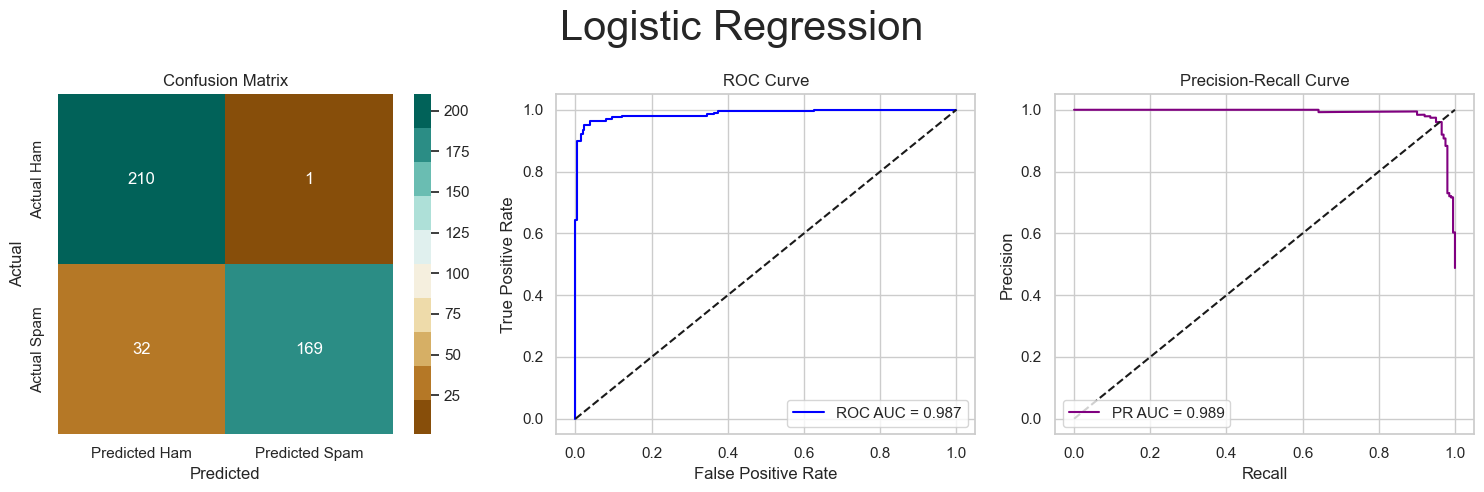

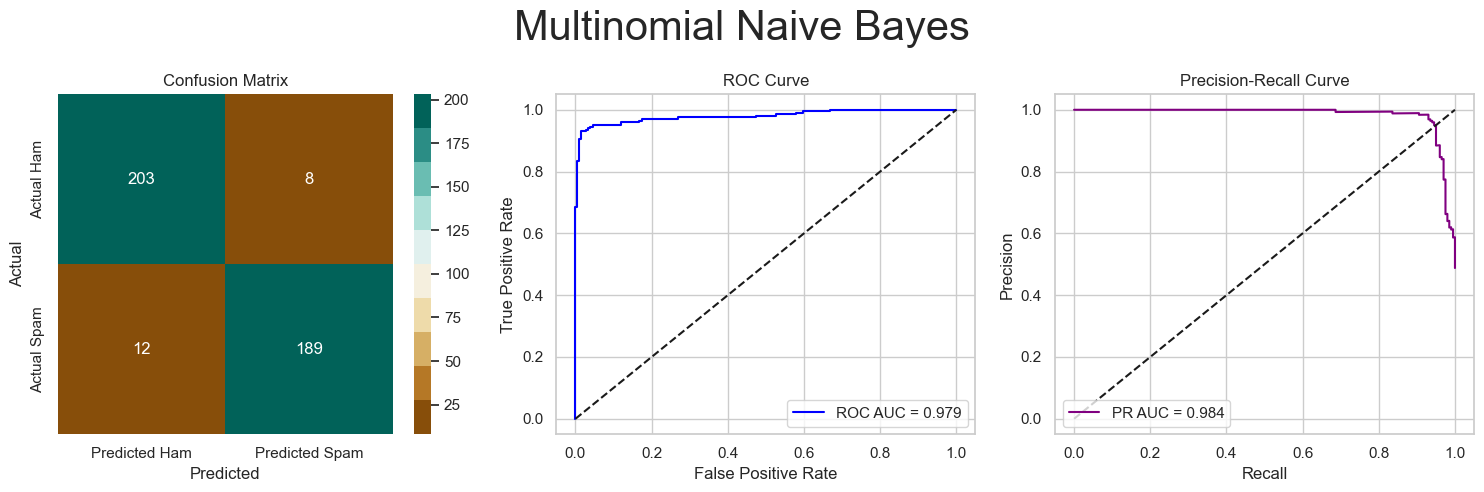

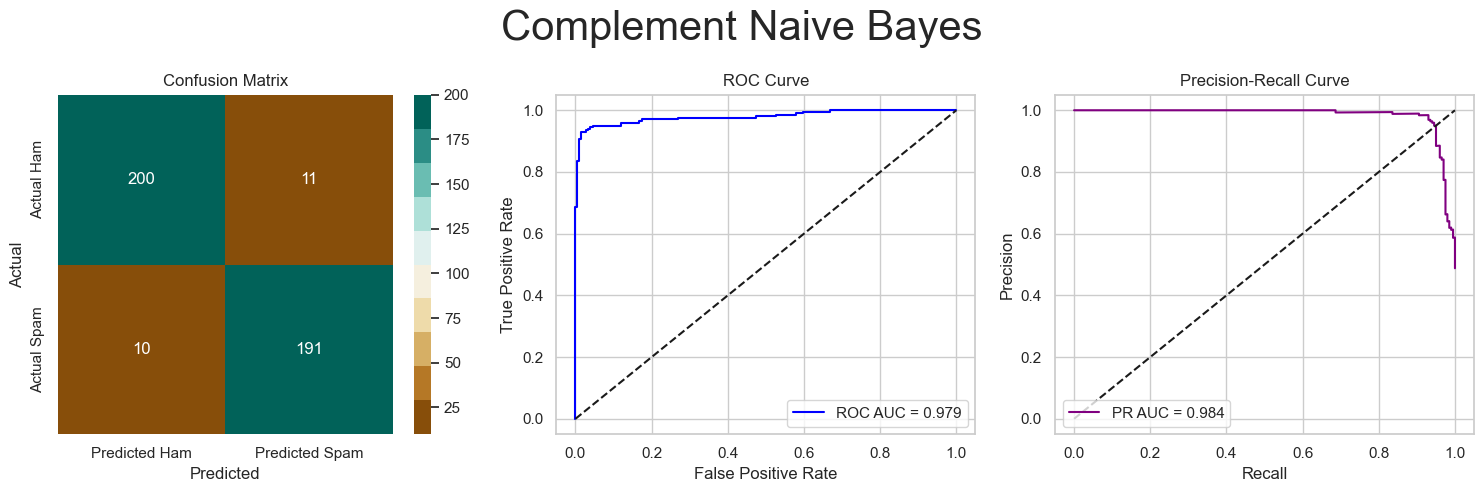

In [222]:
lr_perf = evaluate('Logistic Regression', Y_test, Y_pred_lr, Y_pred_prob_lr)
mnb_perf = evaluate('Multinomial Naive Bayes', Y_test, Y_pred_mnb, Y_pred_prob_mnb)
cnb_perf = evaluate('Complement Naive Bayes', Y_test, Y_pred_cnb, Y_pred_prob_cnb)
plt.show()

In [223]:
perf_comparision = pd.concat([lr_perf, mnb_perf, cnb_perf], axis=1)
perf_comparision

,Logistic Regression,Multinomial Naive Bayes,Complement Naive Bayes
Accuracy,0.919903,0.951456,0.949029
Precision,0.994118,0.959391,0.945545
Recall,0.840796,0.940299,0.950249
F1,0.911051,0.949749,0.947891
ROC-AUC,0.987291,0.979180,0.979180
PR-AUC,0.989150,0.983892,0.983892


# Tuning the models

## Find the best parameters

### Logistic Regression

In [224]:
lr_param = {
    'C': [i / 10 for i in range(1, 101)], 
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': [None, 'balanced'],
}
random_search = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=lr_param, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42, scoring='f1')
random_search.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                              0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4,
                                              1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1,
                                              2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8,
                                              2.9, 3.0, ...],
                                        'class_weight': [None, 'balanced'],
                                        'solver': ['liblinear', 'lbfgs']},
                   random_state=42, scoring='f1', verbose=1)

In [225]:
lr_best_param = random_search.best_params_

### Multinomial Naive Bayes

In [226]:
mnb_param = {
    'alpha': [i / 10 for i in range(1, 101)],
    'fit_prior': [True, False],
}
random_search = RandomizedSearchCV(estimator=MultinomialNB(), param_distributions=mnb_param, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42, scoring='f1')
random_search.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                                  1.9, 2.0, 2.1, 2.2, 2.3, 2.4,
                                                  2.5, 2.6, 2.7, 2.8, 2.9, 3.0, ...],
                                        'fit_prior': [True, False]},
                   random_state=42, scoring='f1', verbose=1)

In [227]:
mnb_best_param = random_search.best_params_

### Complement Naive Bayes

In [228]:
cnb_param = {
    'alpha': [i / 10 for i in range(1, 101)],
    'fit_prior': [True, False],
    'norm': [True, False]
}
random_search = RandomizedSearchCV(estimator=ComplementNB(), param_distributions=cnb_param, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42, scoring='f1')
random_search.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=ComplementNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                                  1.9, 2.0, 2.1, 2.2, 2.3, 2.4,
                                                  2.5, 2.6, 2.7, 2.8, 2.9, 3.0, ...],
                                        'fit_prior': [True, False],
                                        'norm': [True, False]},
                   random_state=42, scoring='f1', verbose=1)

In [229]:
cnb_best_param = random_search.best_params_

## Retrain the model with best parameters

### Logistic Regression

In [230]:
lr_model = LogisticRegression(**lr_best_param)
lr_model.fit(X_train, Y_train)

LogisticRegression(C=5.8, class_weight='balanced')

### Multinomial Naive Bayes

In [231]:
mnb_model = MultinomialNB(**mnb_best_param)
mnb_model.fit(X_train, Y_train)

MultinomialNB(alpha=0.7)

### Complement Naive Bayes

In [232]:
cnb_model = ComplementNB(**cnb_best_param)
cnb_model.fit(X_train, Y_train)

ComplementNB(alpha=0.1, fit_prior=False)

## Reevaluate with the test dataset

In [233]:
Y_pred_lr = lr_model.predict(X_test)
Y_pred_mnb = mnb_model.predict(X_test)
Y_pred_cnb = cnb_model.predict(X_test)

Y_pred_prob_lr = lr_model.predict_proba(X_test)
Y_pred_prob_mnb = mnb_model.predict_proba(X_test)
Y_pred_prob_cnb = cnb_model.predict_proba(X_test)

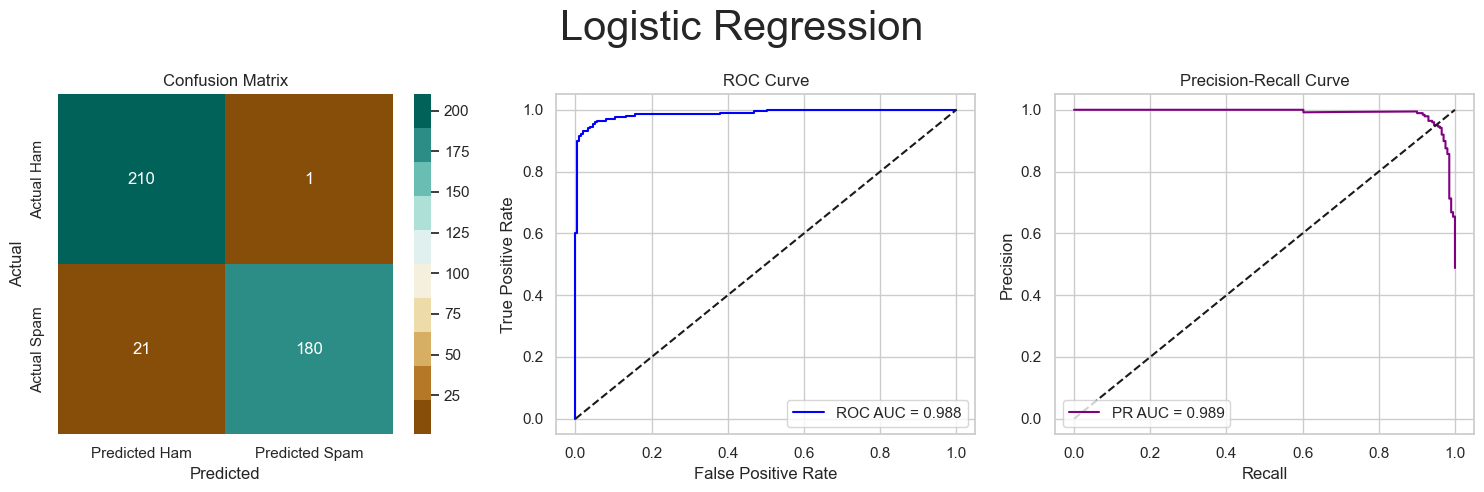

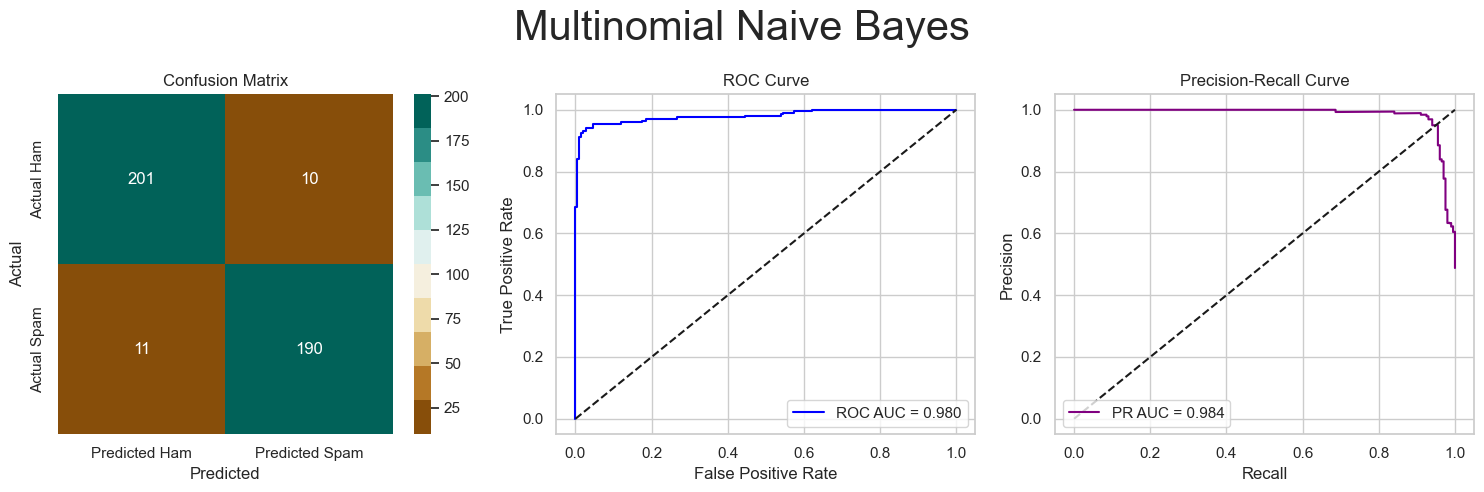

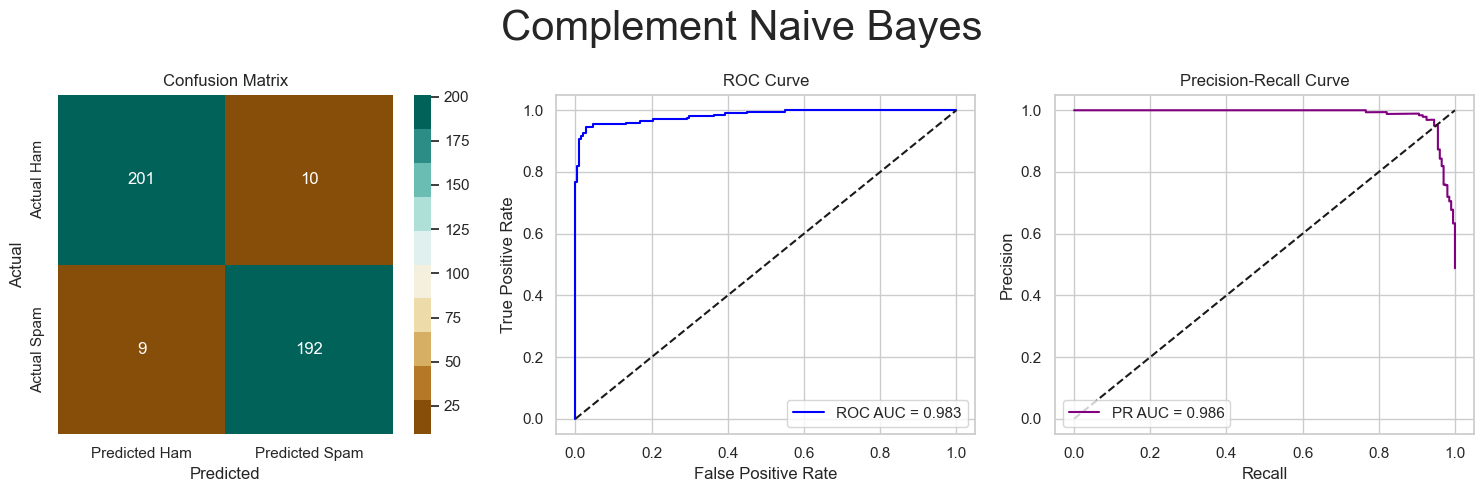

In [234]:
lr_perf = evaluate('Logistic Regression', Y_test, Y_pred_lr, Y_pred_prob_lr)
mnb_perf = evaluate('Multinomial Naive Bayes', Y_test, Y_pred_mnb, Y_pred_prob_mnb)
cnb_perf = evaluate('Complement Naive Bayes', Y_test, Y_pred_cnb, Y_pred_prob_cnb)
plt.show()

In [235]:
perf_comparision = pd.concat([lr_perf, mnb_perf, cnb_perf], axis=1)
perf_comparision

,Logistic Regression,Multinomial Naive Bayes,Complement Naive Bayes
Accuracy,0.946602,0.949029,0.953883
Precision,0.994475,0.950000,0.950495
Recall,0.895522,0.945274,0.955224
F1,0.942408,0.947631,0.952854
ROC-AUC,0.987574,0.980052,0.983353
PR-AUC,0.988910,0.984411,0.986203
